In [1]:
import sys
sys.path.append("Methods/EWC/old")
sys.path.append("HPO_lib/benchmark_loaders")

In [2]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
#from lib.benchmark_generator import PermutedMNIST
from HPO_lib.get_benchmarks import get_benchmarks
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.training.plugins import EWCPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [4]:
device = get_device(1)

## Set parameters

In [5]:
# Benchmark parameter
num_tasks = 3
train_percentage = 0.5

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [6]:
random_seed = 88

## Get p-MNIST benchmark

In [7]:
benchmark_settings = {"benchmark_name" : "pMNIST_via_avalanche",
                      "difficulty" : "standard",
                      "num_tasks" : 3,
                      "train_percentage" : 0.5,
                      "num_val_benchmarks" : 0,
                      "batch_size" : 128}

In [8]:
#benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="hard", seed=random_seed)
benchmarks = get_benchmarks(benchmark_settings, random_seed)

In [9]:
train_loaders_list, val_loaders_list, test_loaders_list = benchmarks[0]

test_loaders_list = []
for test_experience in benchmark.test_stream :
        print(id(test_experience.dataset))
        test_dataset = test_experience.dataset
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        test_loaders_list.append(test_data_loader)

train_loaders_list = []
for test_experience in benchmark.train_stream :
        print(id(test_experience.dataset))
        test_dataset = test_experience.dataset
        test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
        train_loaders_list.append(test_data_loader)

## Define model

In [10]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [11]:
optimizer = get_optimizer(optimizer_name, model)

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, eval_every=-1, #evaluator=eval_plugin,
    device=device
)

print((ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data> 1e-6).sum())

experience = benchmark.train_stream[0]
ewc.plugins[0].compute_importances(model=model,
                                       criterion=get_loss(loss_name),
                                       optimizer=optimizer,
                                       dataset=experience.dataset,
                                       device=device,
                                       batch_size=128)["fc1.weight"].data

ewc.plugins[0].importances

In [13]:
train_loaders_list

In [14]:
test_accs_matrix = np.zeros((num_tasks, num_tasks))
train_accs_matrix = np.zeros((num_tasks, num_tasks))

for task_number, train_loader, test_experience in zip(list(range(num_tasks)), train_loaders_list.train_stream, train_loaders_list.test_stream) : 
    ewc.train(train_loader)
    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)

-- >> Start of training phase << --


100%|██████████| 235/235 [00:03<00:00, 67.13it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5161
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8456
100%|██████████| 235/235 [00:03<00:00, 70.83it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1367
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9586
100%|██████████| 235/235 [00:03<00:00, 68.29it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0978
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9693
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 67.88it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5686
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8585
100%|██████████| 235/235 [00:03<00:00, 68.00it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2501
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9473
100%|██████████| 235/235 [00:03<00:00, 68.06i

In [15]:
test_accs_matrix

array([[96.45, 11.58,  5.32],
       [91.46, 95.97,  7.81],
       [87.16, 88.08, 95.6 ]])

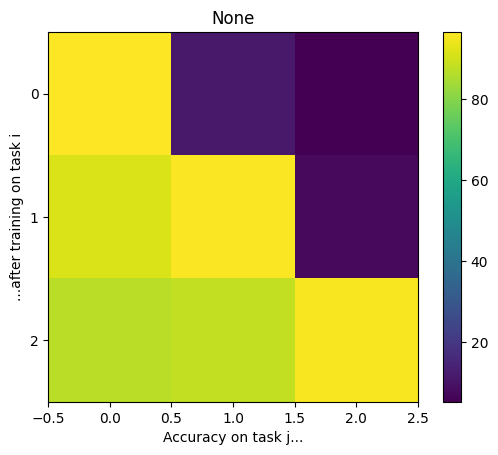

In [16]:
visualize_accs_matrix(test_accs_matrix)

In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
test_accs_matrix = np.zeros((num_tasks, num_tasks))
train_accs_matrix = np.zeros((num_tasks, num_tasks))

for task_number, train_experience, test_experience in zip(list(range(num_tasks)), benchmark.train_stream, benchmark.test_stream) :
    ewc.train(test_experience)
    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)
        train_accs_matrix[task_number,j] = round(test(model, train_loaders_list[j], 128, device),2)

NameError: name 'benchmark' is not defined

## Visualize results

In [ ]:
test_accs_matrix

array([[96.92,  6.54, 12.  ],
       [81.51, 96.24,  8.4 ],
       [89.86, 89.  , 96.27]])

In [ ]:
train_accs_matrix

array([[93.55,  6.74, 12.36],
       [79.34, 92.95,  8.44],
       [86.6 , 86.22, 92.4 ]])

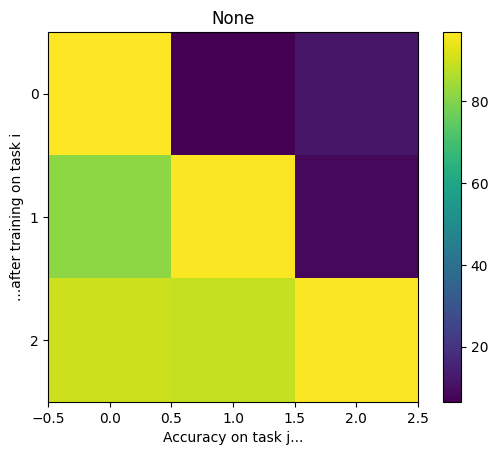

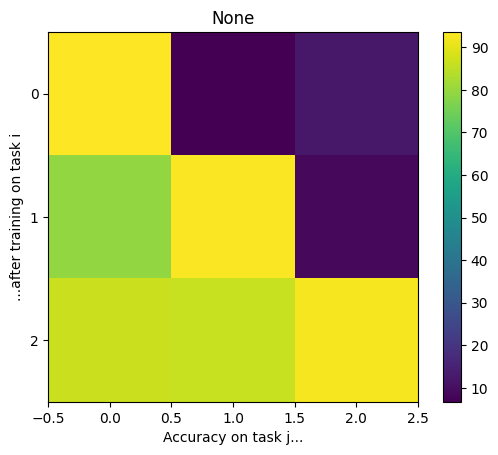

In [ ]:
visualize_accs_matrix(test_accs_matrix)
visualize_accs_matrix(train_accs_matrix)

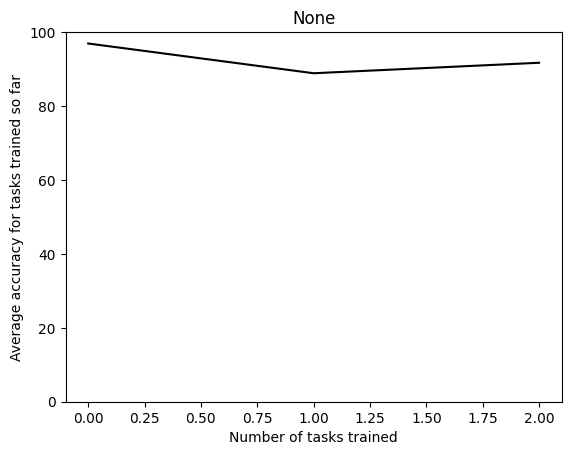

In [ ]:
visualize_avg_acc_curve(test_accs_matrix)

In [ ]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)
optimizer = get_optimizer(optimizer_name, model)

In [ ]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

In [ ]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [ ]:
#ewc.plugins[0].importances[0] = sto[0]
#ewc.plugins[3].train_exp_counter = 1

In [ ]:
ewc.plugins[0].importances[0]
ewc.plugins[3].train_exp_counter

0

In [ ]:
ewc = EWC(
        model=model, 
        optimizer=get_optimizer(optimizer_name, model),
        criterion=get_loss(loss_name),
        ewc_lambda=0,
        train_mb_size=batch_size,
        train_epochs=0, 
        eval_every=-1,
        device=device
    )

In [ ]:
id(ewc.model)

137851487200096

In [ ]:
ewc.train_epochs

0

In [ ]:
sto_ewc = None
test_accs_matrix = np.zeros((num_tasks, num_tasks))
for task_number, train_experience in zip(list(range(num_tasks)), benchmark.train_stream) :
    # Define the EWC Plugin
    if task_number != 0:
        ewc = sto_ewc
    else :
        ewc = EWC(
        model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
        train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
        device=device
        )
    
    if task_number == 2:
        ewc.plugins[0].ewc_lambda = 4000000

    ewc.train(train_experience)

    for j in range(num_tasks) :
        test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], 128, device),2)
    sto_ewc = ewc

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 235/235 [00:03<00:00, 70.04it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8561
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:03<00:00, 67.43it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9563
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 235/235 [00:03<00:00, 69.81it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9664
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 235/235 [00:03<00:00, 67.03it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8667
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9375
 43%|████▎     | 101/235 [00:01<00:01, 67.30it/s]

KeyboardInterrupt: 

 43%|████▎     | 101/235 [00:19<00:01, 67.30it/s]

## Visualize results

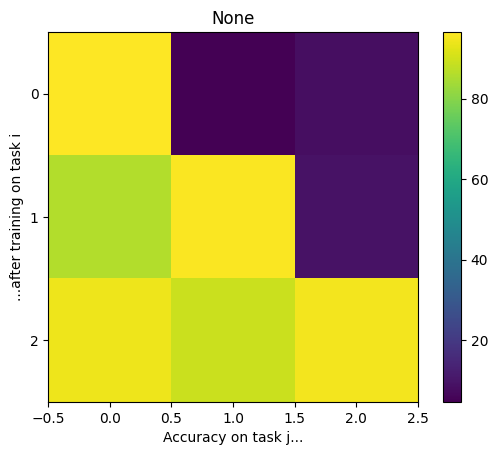

In [ ]:
visualize_accs_matrix(test_accs_matrix)

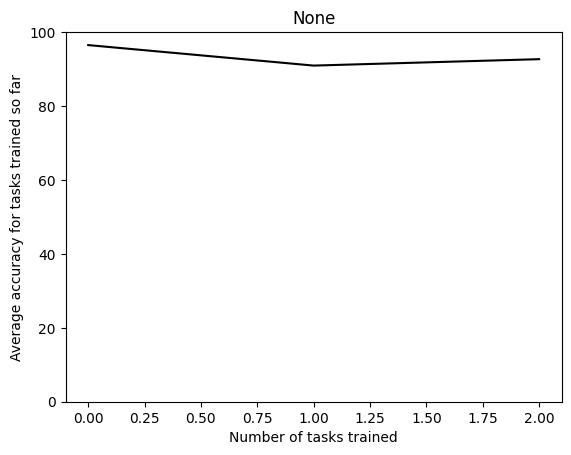

In [ ]:
visualize_avg_acc_curve(test_accs_matrix)